In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from scipy.fft import fft
from scipy.io.wavfile import read
from itertools import permutations
from scipy.interpolate import interp1d

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

Load the .wav files and store them into a dictionary as numpy arrays.

In [2]:
#Load the wave files
#songPathString = './Songs/Lollivox - Optimum Momentum'
songPathString = './Songs/Tevlo - Release Me (feat. Veela)'
songPath = pathlib.Path(songPathString)
channels = {}
for channel in list(songPath.glob('./*.wav')):
    channelName = str(channel)[len(songPathString):-4]
    channel = read(channel)
    channel = np.array(channel[1])
    channel = channel[:, 0]
    channels[channelName] = channel
channelNames = list(channels.keys())

#Some parameters that will be used throughout the code
songLength = 3 * 60 + 40
windowSize = 2**12
samplingFrequency = len(channels['Master']) / songLength
time = np.arange(0, songLength, 1/samplingFrequency)

#Print the channel names as a reference
print(channelNames)

C:\Users\BGH360\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  


['Arp', 'Breaths', 'Build up drums', 'Chords', 'Current', 'Drop Hat', 'Drum send', 'Hats', 'Kick', 'Lead 1', 'Lead add', 'Master', 'Perc', 'Sc', 'Snap', 'Snare', 'Sub kick', 'Vox harms', 'Vox']


We plot the raw song files to help visualize the original data

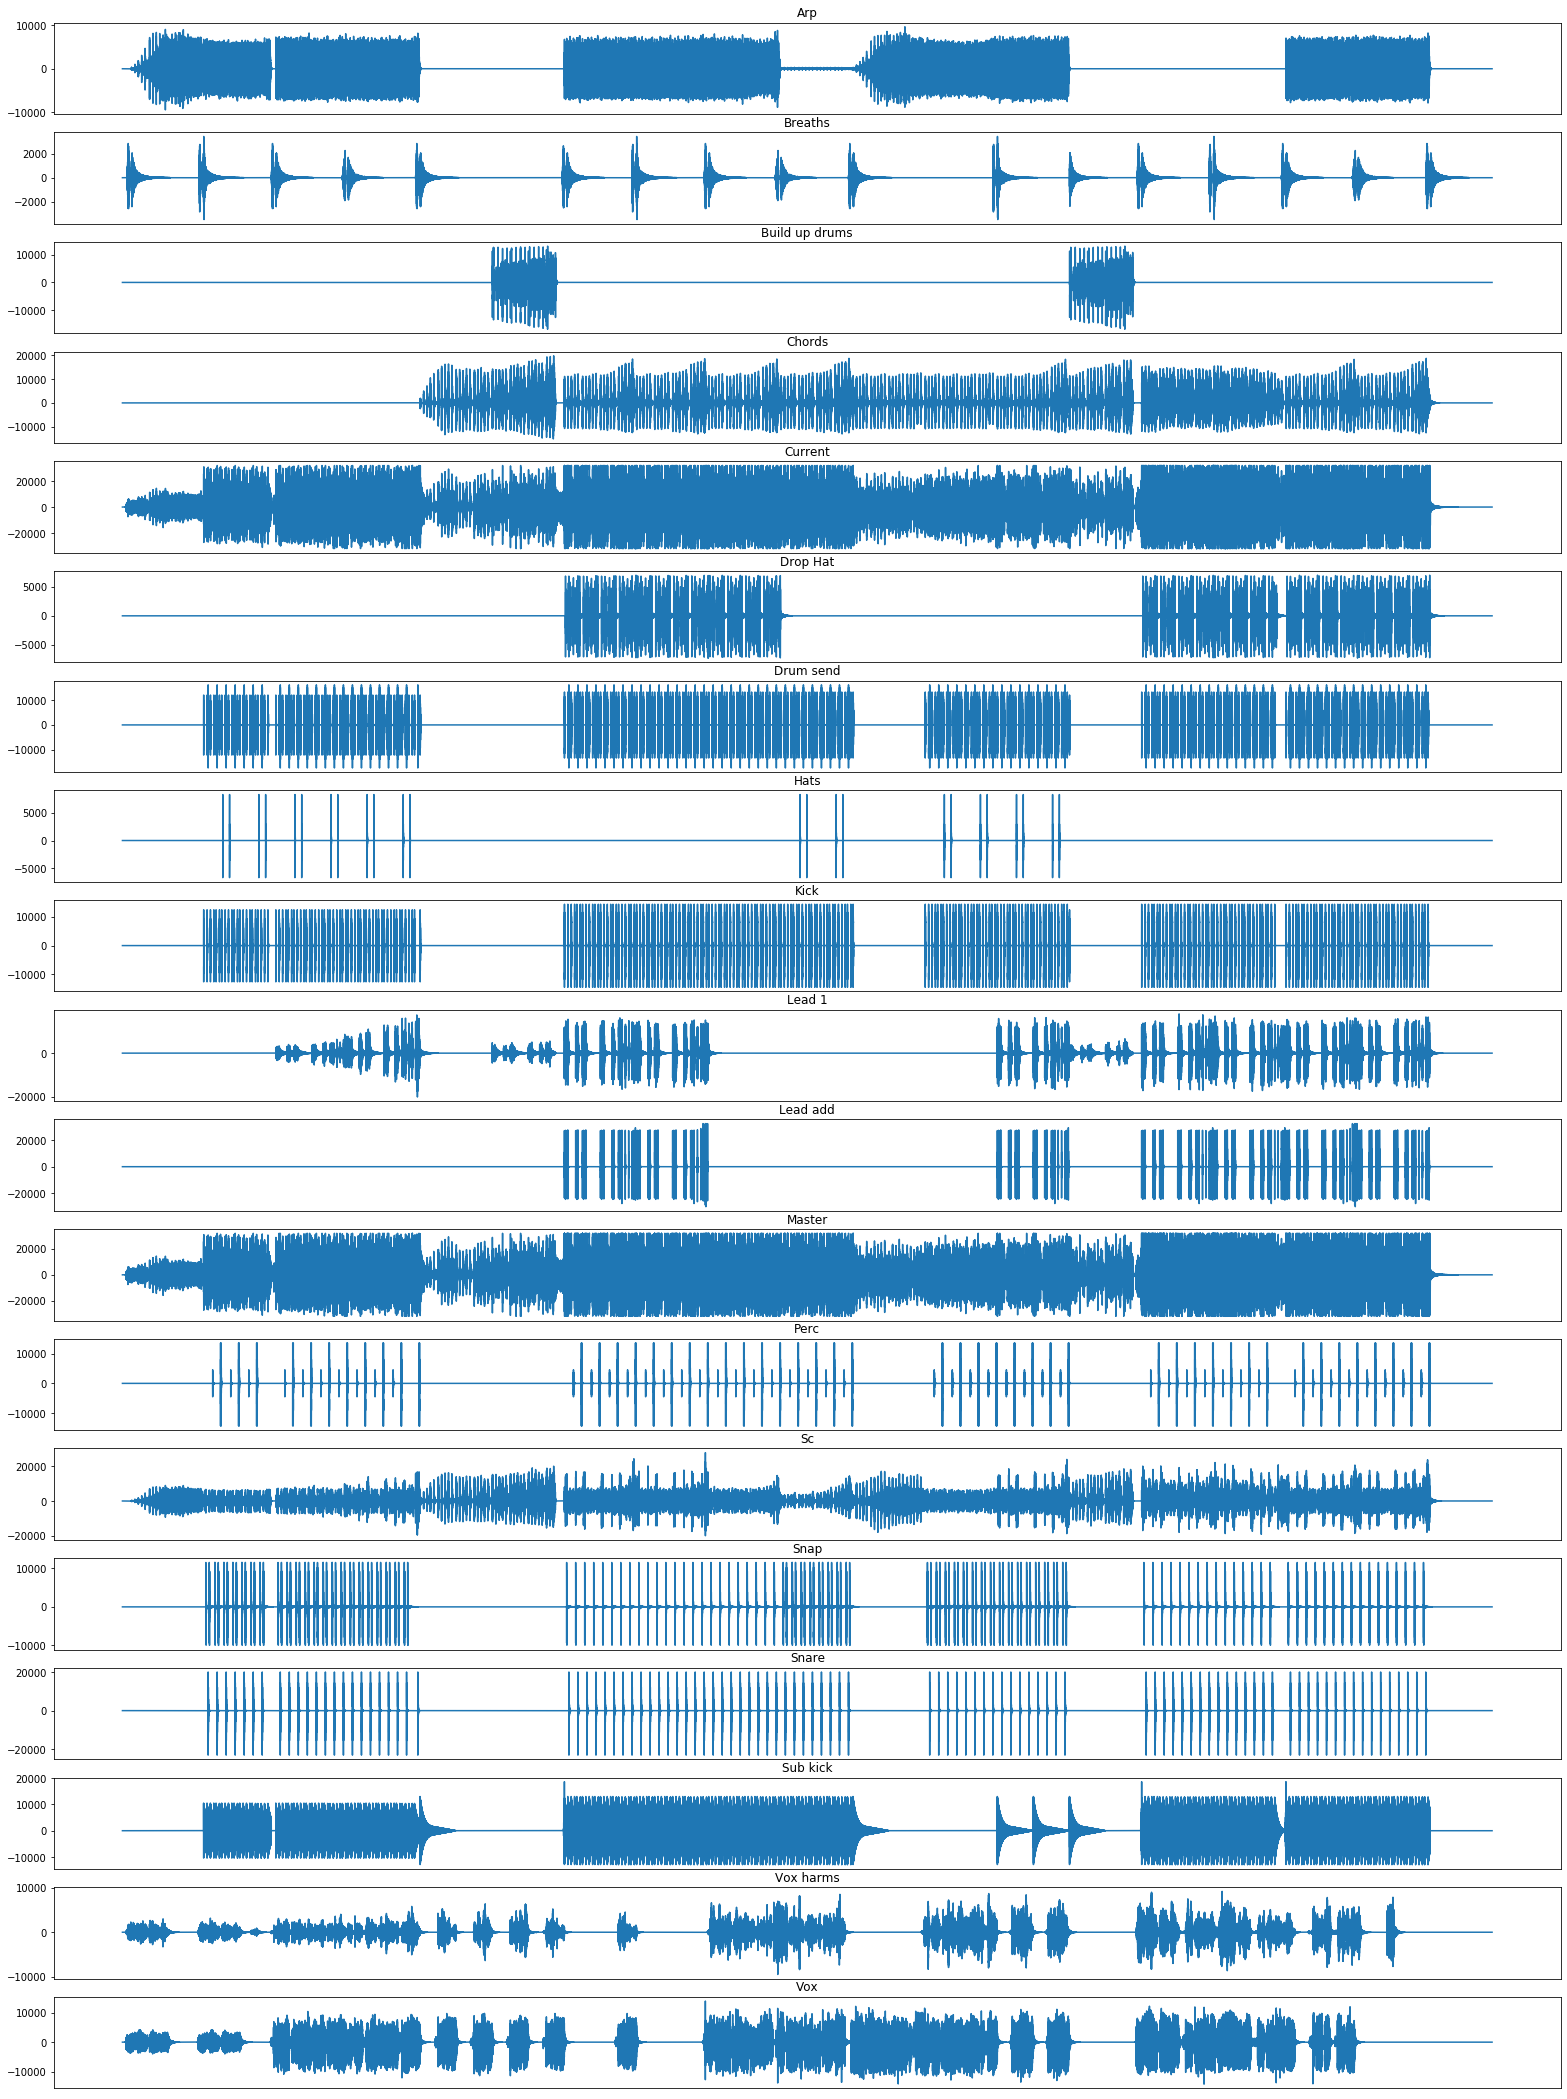

In [3]:
fig, axs = plt.subplots(len(channelNames))
fig.set_figheight(2 * len(channelNames))
fig.set_figwidth(27)
for i, name in enumerate(channelNames):
    axs[i].plot(channels[name])
    axs[i].set_title(name)
    axs[i].set_xticks([])

Get the fourier transform given a time series

In [4]:
def getFourierFromTimeSeries(series):
    
    #Calculate the fourier transform for a snipplet of the song
    fourierTrans = fft(series)[0:len(series)//2]
    fourierTrans = np.abs(fourierTrans)
    
    #Get the frequencies corresponding to the fourier transform that will be used for the x-axis
    frequency = np.linspace(0, samplingFrequency/2, len(fourierTrans))
    frequency = np.log10(frequency)
    frequencyIsInfinity = ~ np.isinf(frequency)
    frequency = frequency[frequencyIsInfinity]
    
    #Normalize the fourier transform and return values
    fourierTrans = fourierTrans[frequencyIsInfinity]
    trapezoidal = 2 * (frequency[1:] - frequency[:-1]) * ((fourierTrans[1:] + fourierTrans[:-1]) / 2)
    fourierTrans = fourierTrans / np.sum(trapezoidal)
    return frequency, fourierTrans

#An old function that was in the code and I can't be bothered fixing them
def getFourierTransformAtIndex(series, idx):
    snipplet = series[idx:idx+windowSize]
    frequency, fourierTrans = getFourierFromTimeSeries(snipplet)
    return frequency, fourierTrans

We provide a comparison of the x axis being scaled and not scaled.

Text(0.5, 0, 'Frequency  log10(Hz)')

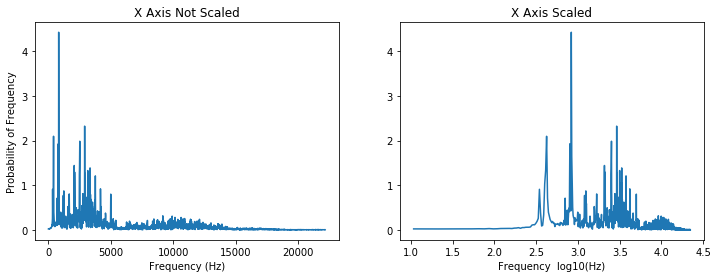

In [5]:
#Get the data to plot
sampleAt = int(20 * samplingFrequency)
snipplet = channel[sampleAt : sampleAt+windowSize]
x, transform = getFourierFromTimeSeries(snipplet)
xNotScaled = np.linspace(0, samplingFrequency/2, windowSize//2)

#Plot the data and format plots
fig, axs = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(12)
axs[0].plot(xNotScaled[1:], transform)
axs[0].set_title('X Axis Not Scaled')
axs[0].set_xlabel('Frequency (Hz)')
axs[0].set_ylabel('Probability of Frequency')
axs[1].plot(x, transform)
axs[1].set_title('X Axis Scaled')
axs[1].set_xlabel('Frequency  log10(Hz)')

In [6]:
def getFourierEntropy(channel):
    
    #We iterate over the whole channel waveform and store results from sliding window as lists
    time, entropies = [], []
    for i in range(len(channel) // windowSize):
        t = i * windowSize / samplingFrequency
        time.append(t)
        
        #Get the fourier transform for this sliding window
        idx = i * windowSize
        snipplet = channel[idx:idx+windowSize]
        freq, transform = getFourierFromTimeSeries(snipplet)
        
        #We weigh the transform based on the trapezoidal rule and calculate the entropy for this window
        weightedTransform =  (freq[1:] - freq[:-1]) * (transform[1:] + transform[:-1]) / 2
        localEntropy = weightedTransform * np.log2(weightedTransform)
        entropy = - np.sum(localEntropy)
        entropies.append(entropy)
    return time, entropies

We plot the entropy for all channels in the song

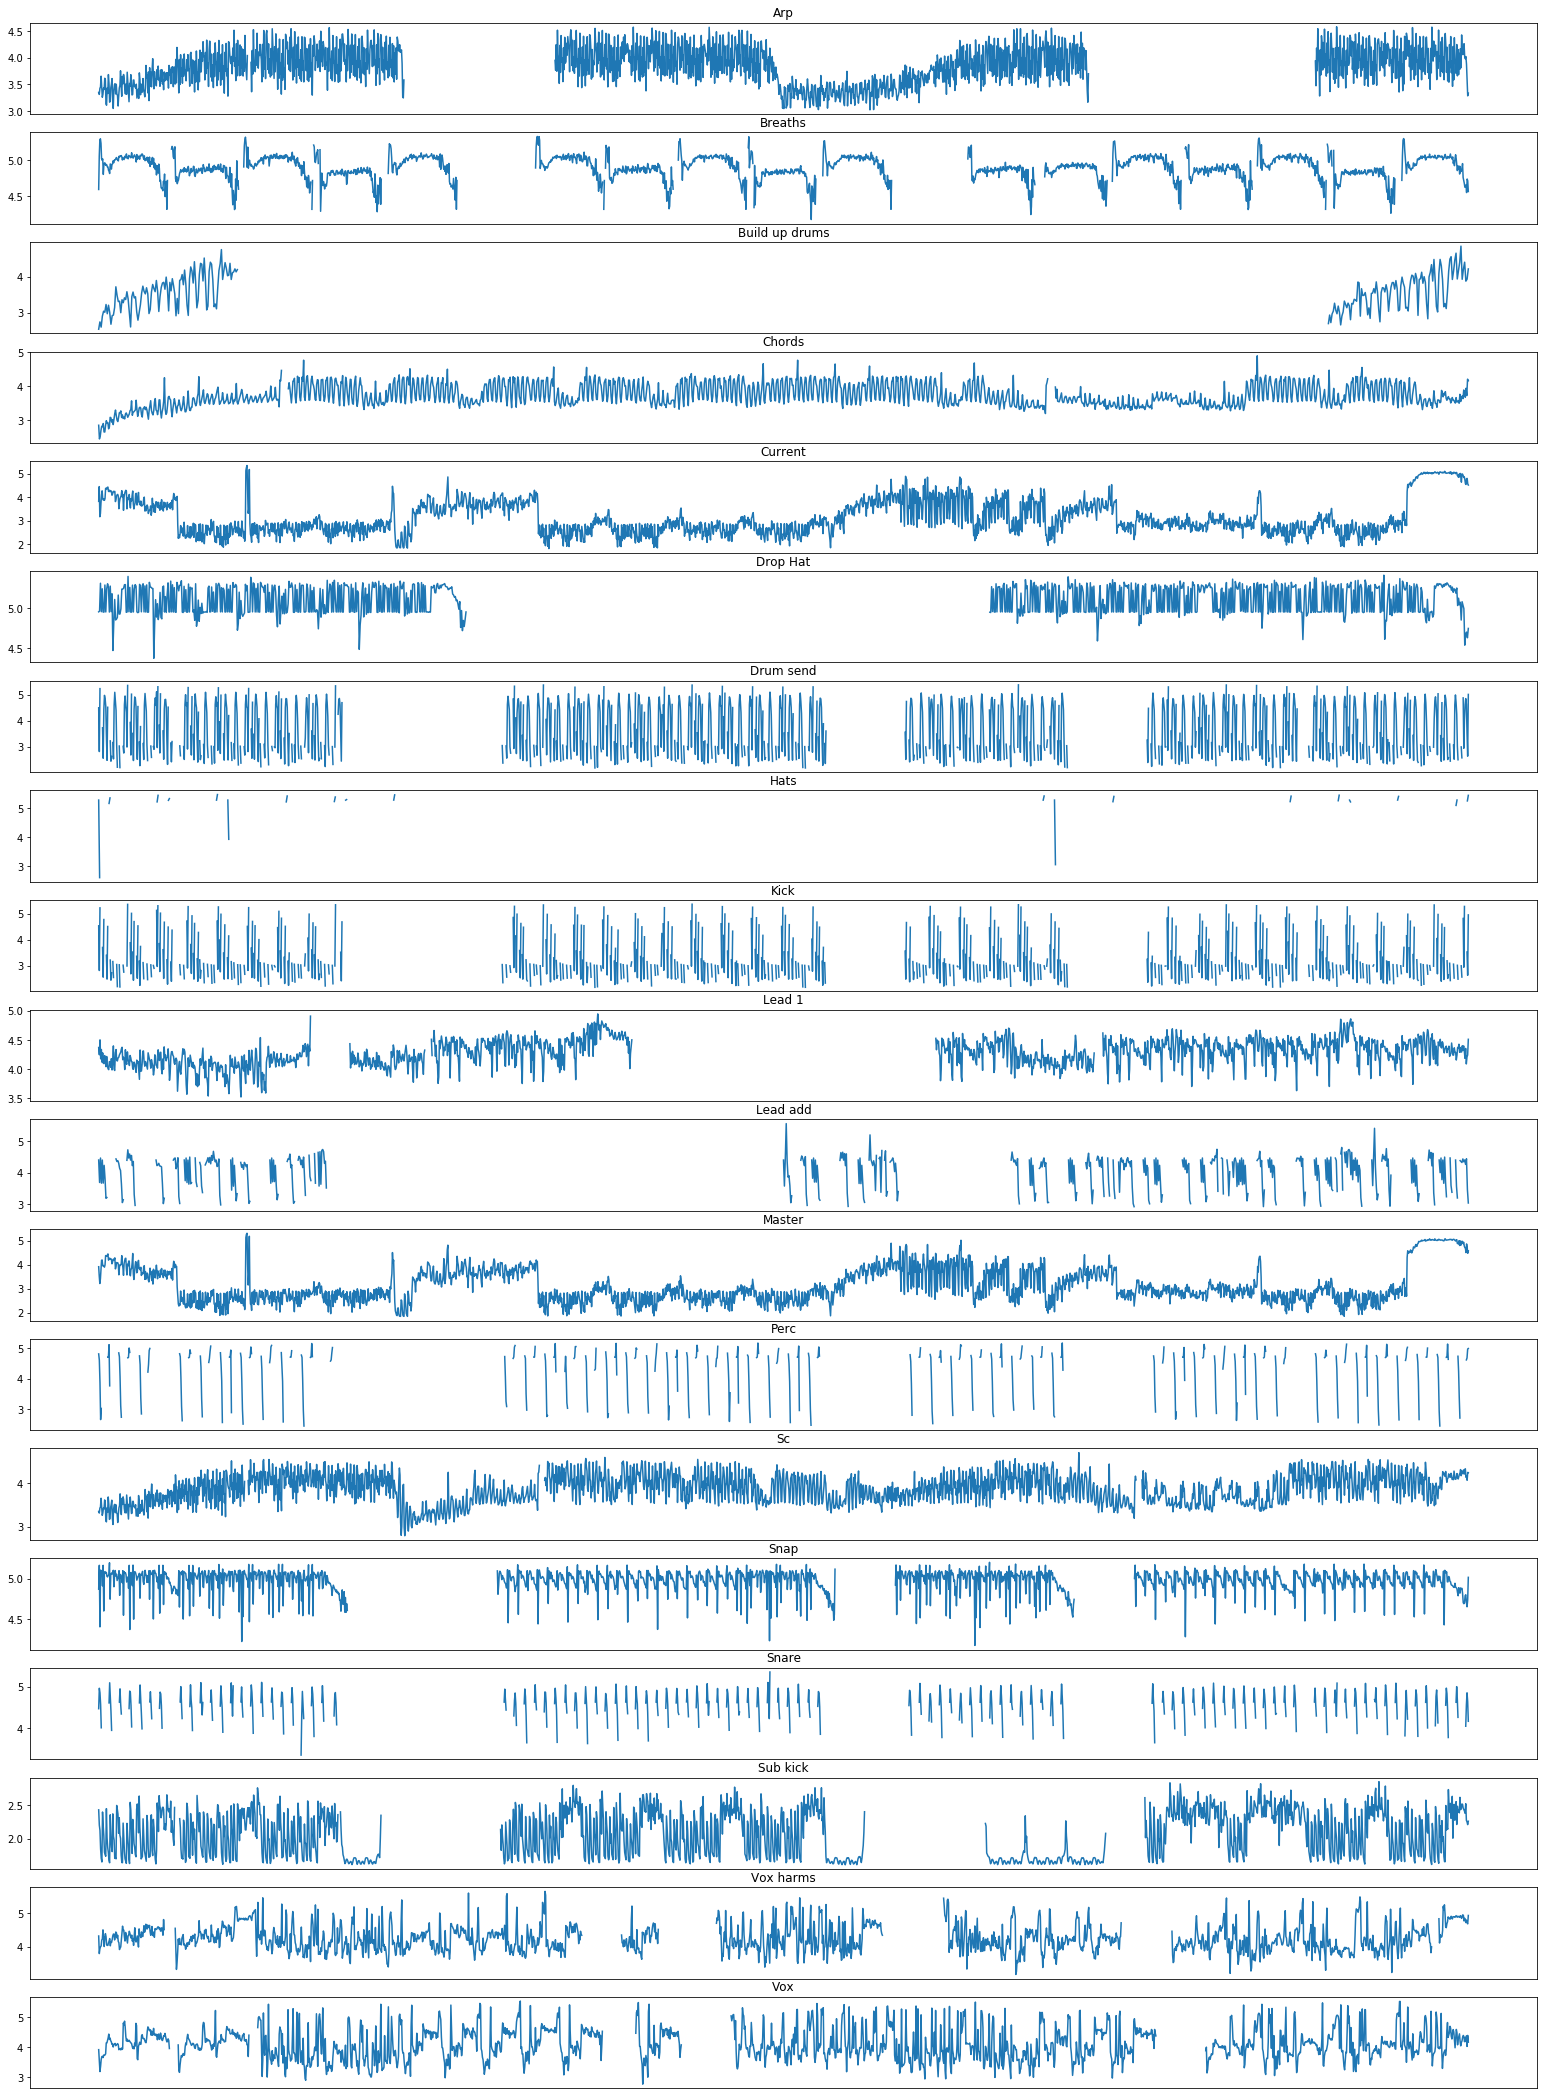

In [7]:
fig, axs = plt.subplots(len(channelNames))
fig.set_figheight(2 * len(channelNames))
fig.set_figwidth(27)
for i, name in enumerate(channelNames):
    t, ents = getFourierEntropy(channels[name])
    axs[i].plot(t, ents)
    axs[i].set_title(name)
    axs[i].set_xticks([])

More plots that are used in our report

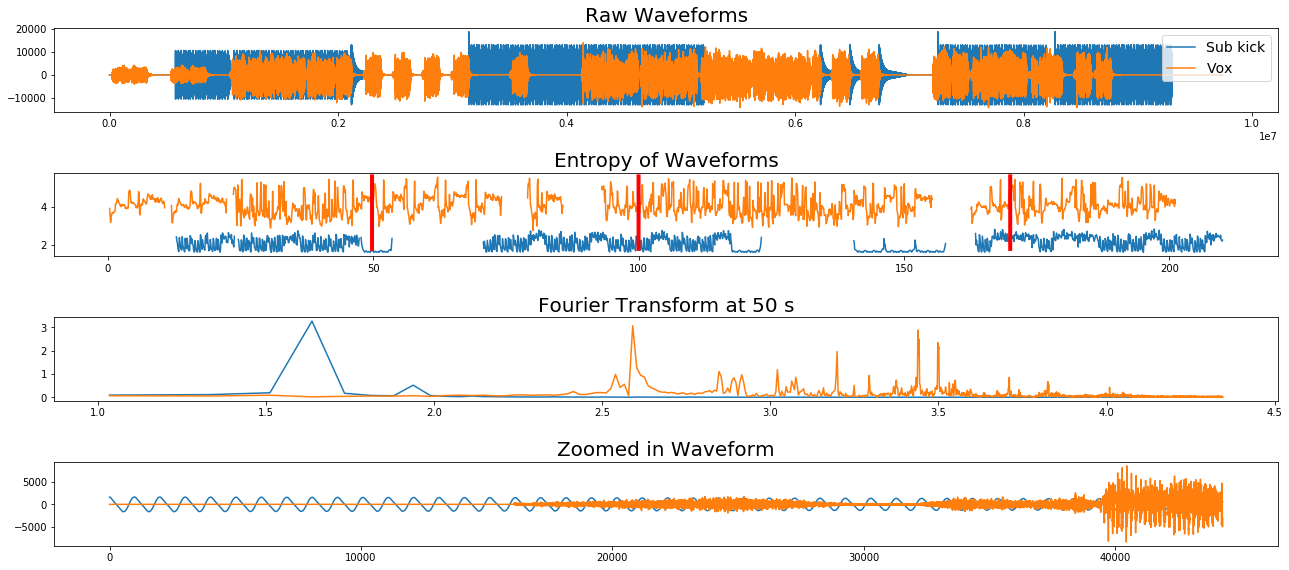

In [8]:
chan1 = 'Sub kick'
chan2 = 'Vox'
time = 49.8

tMaster, entMaster = getFourierEntropy(channels[chan1])
tVocals, entVocals = getFourierEntropy(channels[chan2])
freq, fourierMaster = getFourierTransformAtIndex(channels[chan1], int(time * samplingFrequency))
freq, fourierVocals = getFourierTransformAtIndex(channels[chan2], int(time * samplingFrequency))

fig, axs = plt.subplots(4)
fig.set_figheight(8)
fig.set_figwidth(18)
axs[0].plot(channels[chan1])
axs[0].plot(channels[chan2])
axs[1].plot(tMaster, entMaster)
axs[1].plot(tVocals, entVocals)
axs[2].plot(freq, fourierMaster)
axs[2].plot(freq, fourierVocals)
axs[3].plot(channels[chan1][int(time * samplingFrequency) : int((time+1) * samplingFrequency)])
axs[3].plot(channels[chan2][int(time * samplingFrequency) : int((time+1) * samplingFrequency)])
#axs[2].set_ylim((0, 1))

axs[0].set_title('Raw Waveforms', fontsize=20)
axs[1].set_title('Entropy of Waveforms', fontsize=20)
axs[2].set_title('Fourier Transform at 50 s', fontsize=20)
axs[3].set_title('Zoomed in Waveform', fontsize=20)
axs[0].legend([chan1, chan2], prop={'size': 14}, loc=1)
axs[1].plot([time, time + 0.001], [1.8, 5.6], color='r', linewidth=4)
axs[1].plot([100, 100 + 0.001], [1.8, 5.6], color='r', linewidth=4)
axs[1].plot([170, 170 + 0.001], [1.8, 5.6], color='r', linewidth=4)
fig.tight_layout(pad=1.0)

We write a function for calculating the active information storage of a channel.

In [9]:
def getInformationStorage(channel, history):
    
    #We iterate over the whole channel waveform and store results from sliding window as lists
    time, infoStorage = [], []
    for i in range(history+1, len(channel) // windowSize):
        t = i * windowSize / samplingFrequency
        time.append(t)
        
        #Get the snipplets that we will use to calculate probabilities from
        currentAndPast = channel[(i - history - 1) * windowSize : i * windowSize]
        current = channel[(i - 1) * windowSize : i * windowSize]
        past = channel[(i - history - 1) * windowSize : (i - 1) * windowSize]
        
        #Get the probabilities
        freq, probsCurrentAndPast = getFourierFromTimeSeries(currentAndPast)
        freqCurrent, probsCurrent = getFourierFromTimeSeries(current)
        freqPast, probsPast = getFourierFromTimeSeries(past)
        
        #Interpolate the arrays to make sure they all have the same length
        interpCandP = interp1d(freq, probsCurrentAndPast, kind='cubic')
        interpP = interp1d(freqPast, probsPast, kind='cubic')
        pastAndCurInterpolated = interpCandP(freqCurrent)
        pastInterpolated = interpP(freqCurrent)
        
        #Calculate the fraction term that is in the local information storage
        probsNowGivenPast = pastAndCurInterpolated / pastInterpolated
        normalizationConstant = (freqCurrent[1:] - freqCurrent[:-1]) * (probsNowGivenPast[1:] + probsNowGivenPast[:-1]) / 2
        probsNowGivenPast = probsNowGivenPast / np.sum(normalizationConstant)
        fractionTerm = probsNowGivenPast / probsCurrent
        
        #Weigh the fraction term and remove nan values
        weightedFract = (freqCurrent[1:] - freqCurrent[:-1]) * (fractionTerm[1:] + fractionTerm[:-1]) / 2
        localActiveInfo = np.log2(weightedFract)
        localActiveInfo = localActiveInfo[~np.isnan(localActiveInfo)]
        
        #Append to our results
        infoStorage.append(np.mean(localActiveInfo))
    return time, infoStorage

We calculate the information storage for all song and plot them.

In [10]:
infoStoresTwo, infoStoresSix = [], []
for i, name in enumerate(channelNames):
    tTwo, info = getInformationStorage(channels[name], 1)
    infoStoresTwo.append(info)
    tSix, info = getInformationStorage(channels[name], 6)
    infoStoresSix.append(info)

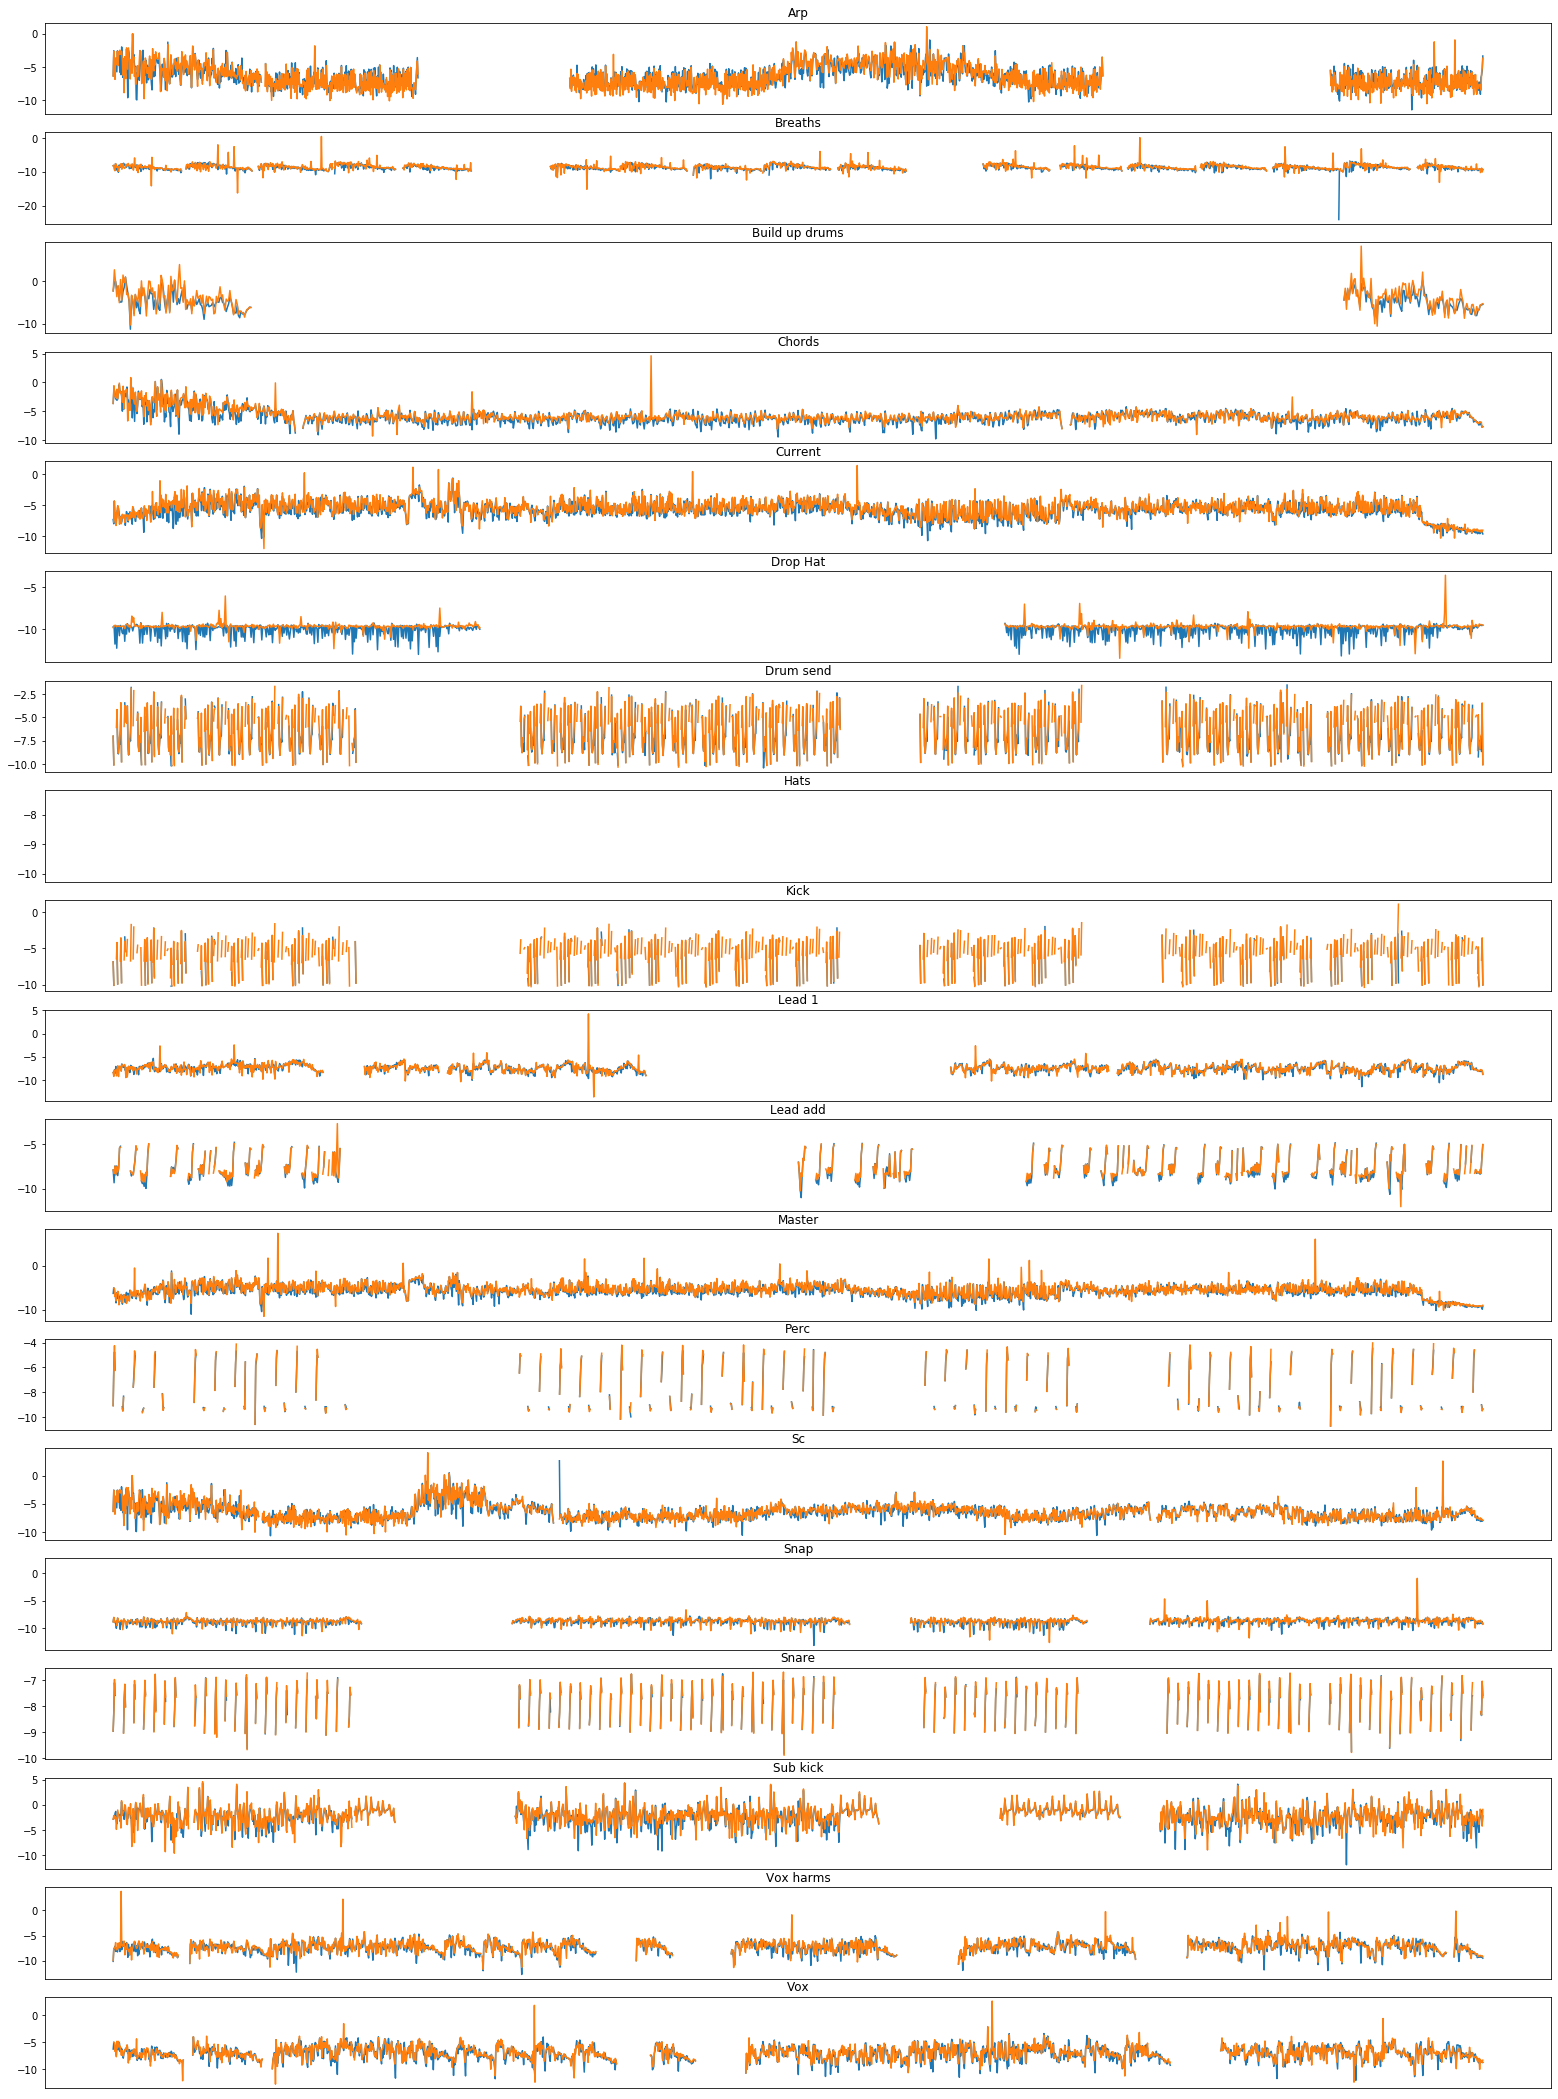

In [11]:
fig, axs = plt.subplots(len(channelNames))
fig.set_figheight(2 * len(channelNames))
fig.set_figwidth(27)
for i, info in enumerate(infoStoresTwo):
    axs[i].plot(tTwo, info)
    axs[i].plot(tSix, infoStoresSix[i])
    axs[i].set_title(channelNames[i])
    axs[i].set_xticks([])

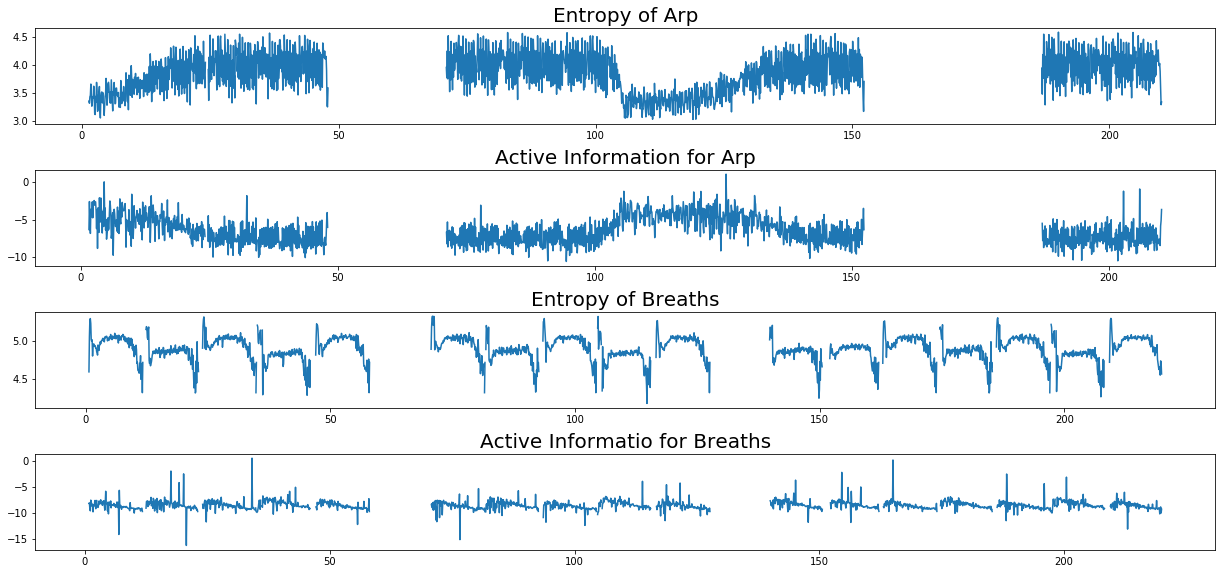

In [12]:
chan1 = 'Arp'
chan2 = 'Breaths'

tArp, entArp = getFourierEntropy(channels[chan1])
tBreaths, entBreaths = getFourierEntropy(channels[chan2])
tA, inforArp = getInformationStorage(channels[chan1], 6)
tB, inforBreaths = getInformationStorage(channels[chan2], 6)

fig, axs = plt.subplots(4)
fig.set_figheight(8)
fig.set_figwidth(17)
axs[0].plot(tArp, entArp)
axs[1].plot(tA, inforArp)
axs[2].plot(tBreaths, entBreaths)
axs[3].plot(tB, inforBreaths)

axs[0].set_title('Entropy of Arp', fontsize=20)
axs[1].set_title('Active Information for Arp', fontsize=20)
axs[2].set_title('Entropy of Breaths', fontsize=20)
axs[3].set_title('Active Informatio for Breaths', fontsize=20)
fig.tight_layout(pad=0.8)

We define functions for calculating the permutation entropy.

In [13]:
#Get the permutation entropy of a single window
def permutationEntropy(X, embedingDimension):
    
    #Create a list of all possible permutations, and a list to store the counts of each permutation in our time series
    perms = list(permutations(list(range(embedingDimension))))
    permCounts = np.zeros(len(perms))
    
    #Slide over the snipplet to count the permutations
    iterations = X.shape[0] - embedingDimension + 1
    for i in range(iterations):
        subsequents = X[i : i+embedingDimension]
        permutation = tuple(np.argsort(subsequents))
        idx = perms.index(permutation)
        permCounts[idx] += 1
    
    #Remove zeroes and calculate the permutation entropy
    isZero = (permCounts == 0)
    permCounts += 0.0001 * isZero
    permProb = permCounts / sum(permCounts)
    permEntropy = - np.sum(permProb * np.log2(permProb) * (1-isZero))
    return permEntropy, permProb

#Gets a list of normalized permutation entropies of a time series X using a sliding window approach
def getPermuationEntropies(X, embeddingDimension, window, delay):
    
    #Filter out values in X with accordance to the embedding delay
    X = X[(np.array(range(len(X))) % delay == 0)]
    
    #Use a sliding window to cut the time series into snipplets and calculate their permutation entropies
    permutationEntropies = []
    iterations = (len(X)//window) + 1
    for i in range(iterations):
        x = X[i*window : (i+1)*window]
        permEnt, permProb = permutationEntropy(x, embeddingDimension)
        permutationEntropies.append(permEnt)
    
    #Normalize the permutation entropy and return results
    permutationEntropies = np.array(permutationEntropies)
    return permutationEntropies

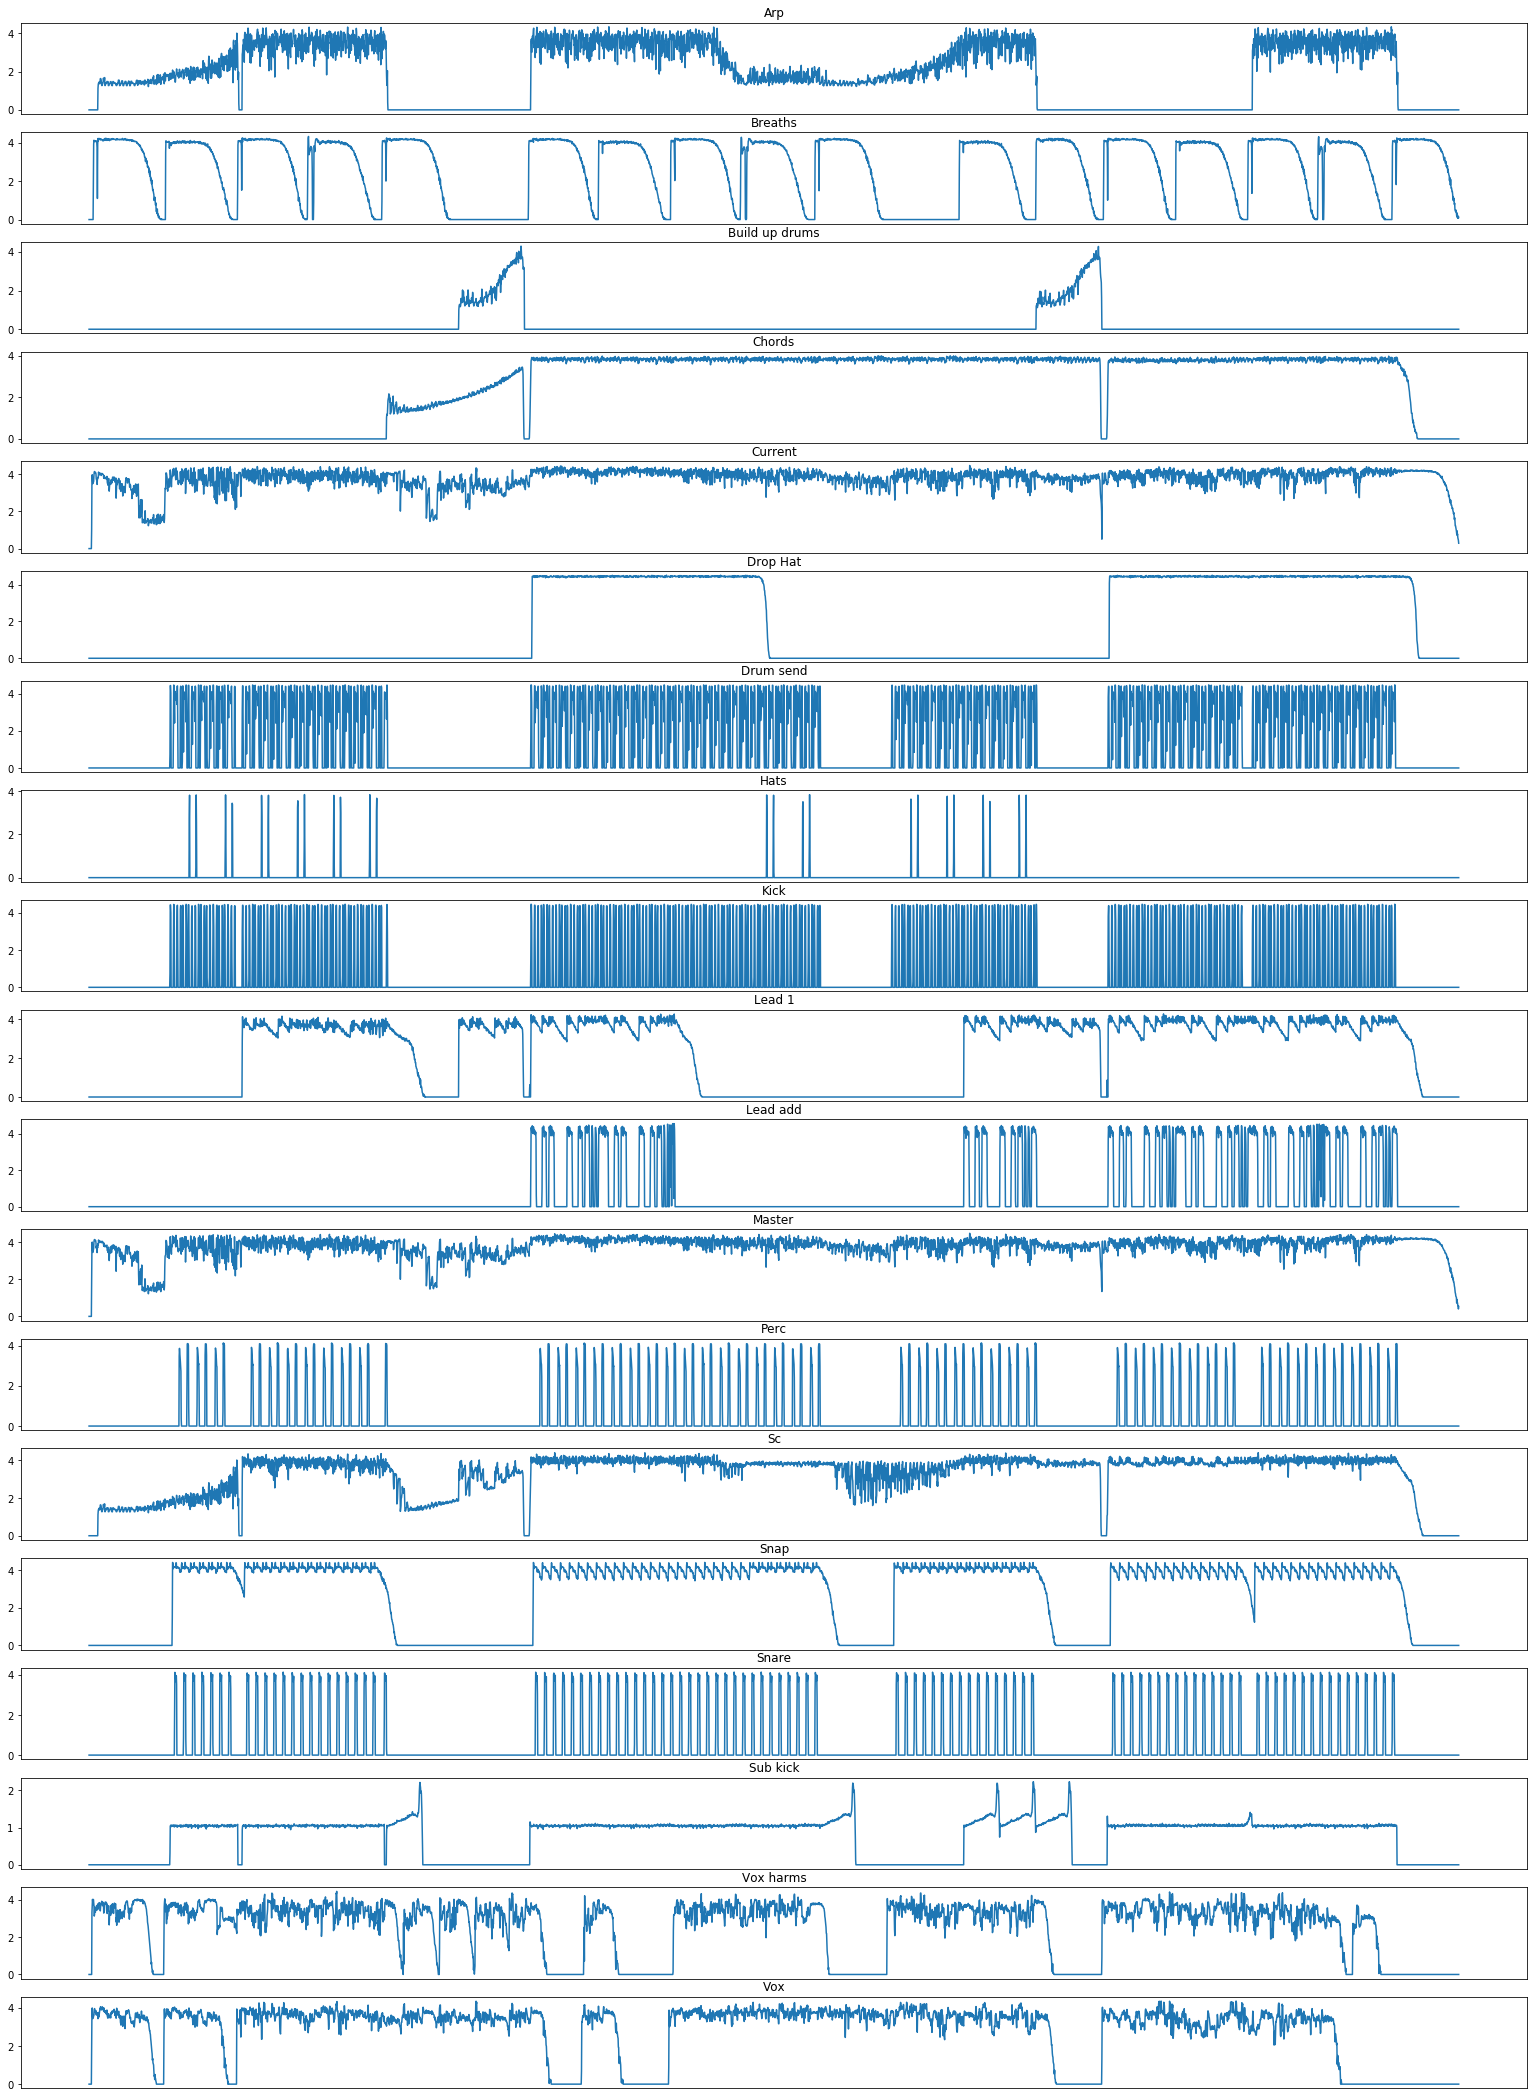

In [14]:
embeddingDimension, window, windowStepSize, tao = 4, 2048, 2048, 1

fig, axs = plt.subplots(len(channelNames))
fig.set_figheight(2 * len(channelNames))
fig.set_figwidth(27)

permutationEnts = []
for i, name in enumerate(channelNames):
    ents = getPermuationEntropies(channels[name], embeddingDimension, window, tao)
    permutationEnts.append(ents)
    
    axs[i].plot(ents)
    axs[i].set_title(name)
    axs[i].set_xticks([])

Provide plots comparing the fourier and permutation probabilities.

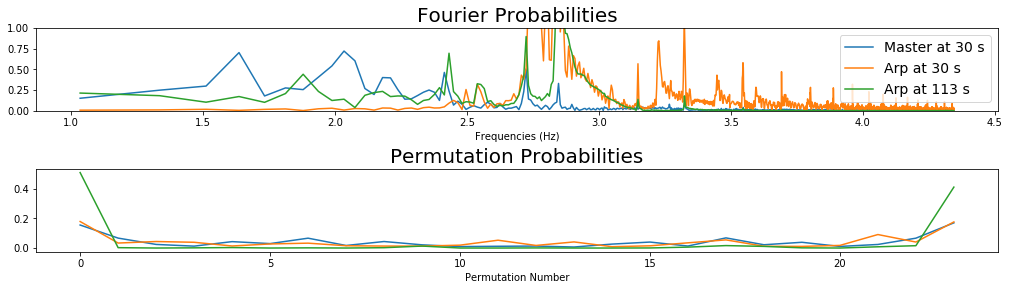

In [15]:
time = 30
t2 = 113
freq, fourierMaster = getFourierTransformAtIndex(channels['Master'], int(time * samplingFrequency))
freqArp, fourierArp = getFourierTransformAtIndex(channels['Arp'], int(time * samplingFrequency))
freqArp2, fourierArp2 = getFourierTransformAtIndex(channels['Arp'], int(t2 * samplingFrequency))


embeddingDimension, window, windowStepSize, tao = 4, 2048, 2048, 1
idx = int(time * samplingFrequency)

mast = channels['Master']
mastSnipplet = mast[idx : idx + windowSize]
mastPermEnt, mastPermProbs = permutationEntropy(mastSnipplet, embeddingDimension)

arp = channels['Arp']
arpSnipplet = arp[idx : idx + windowSize]
arpPermEnt, arpPermProbs = permutationEntropy(arpSnipplet, embeddingDimension)

idx = int(t2 * samplingFrequency)
arpSnipplet2 = arp[idx : idx + windowSize]
arpPermEnt2, arpPermProbs2 = permutationEntropy(arpSnipplet2, embeddingDimension)

fig, axs = plt.subplots(2)
fig.set_figheight(4)
fig.set_figwidth(14)

axs[0].plot(freq, fourierMaster)
axs[0].plot(freqArp, fourierArp)
axs[0].plot(freqArp2, fourierArp2)
axs[1].plot(mastPermProbs)
axs[1].plot(arpPermProbs)
axs[1].plot(arpPermProbs2)

axs[0].set_title('Fourier Probabilities', fontsize=20)
axs[1].set_title('Permutation Probabilities', fontsize=20)

axs[0].set_xlabel('Frequencies (Hz)')
axs[1].set_xlabel('Permutation Number')

axs[0].set_ylim((0, 1))
axs[0].legend(['Master at 30 s', 'Arp at 30 s', 'Arp at 113 s'], prop={'size': 14}, loc=1)

fig.tight_layout(pad=0.6)

Code for generating code based on discussion section of report.

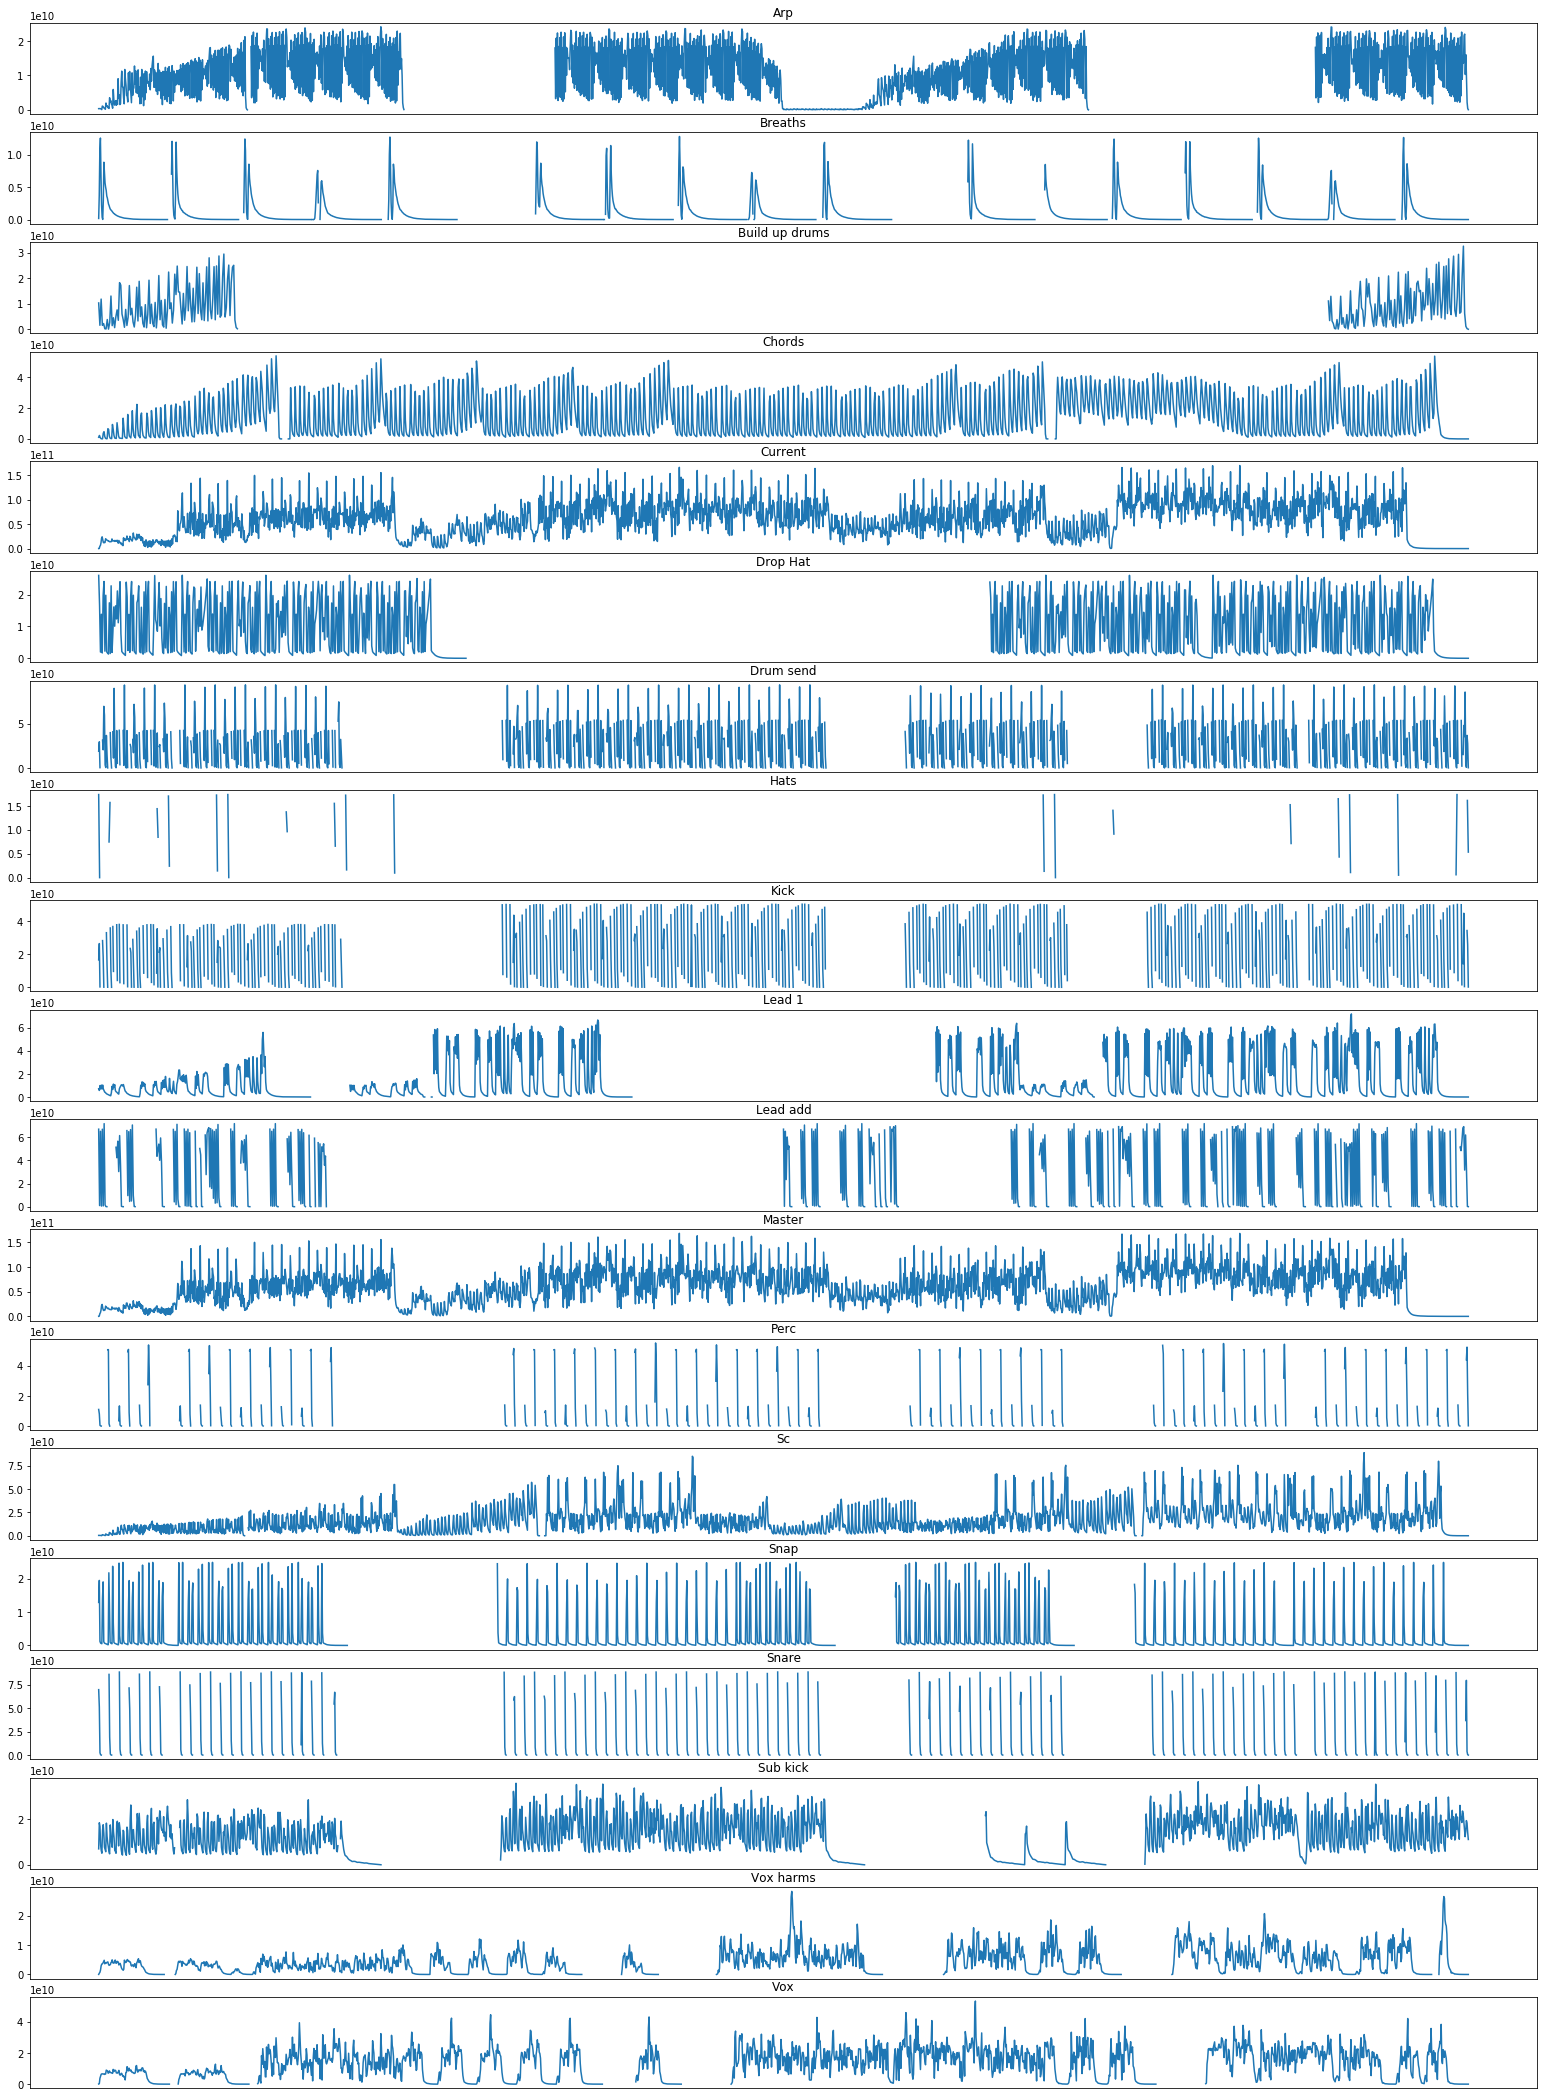

In [16]:
def getModifiedFourier(series):
    
    #Calculate the fourier transform for a snipplet of the song
    fourierTrans = fft(series)[0:len(series)//2]
    fourierTrans = np.abs(fourierTrans)
    
    #Get the frequencies corresponding to the fourier transform that will be used for the x-axis
    frequency = np.linspace(0, samplingFrequency/2, len(fourierTrans))
    frequencyIsInfinity = ~ np.isinf(frequency)
    frequency = frequency[frequencyIsInfinity]
    
    fourierTrans = fourierTrans[frequencyIsInfinity]
    return frequency, fourierTrans

def getModifiedFourierEntropy(channel):
    
    #We iterate over the whole channel waveform and store results from sliding window as lists
    time, entropies = [], []
    for i in range(len(channel) // windowSize):
        t = i * windowSize / samplingFrequency
        time.append(t)
        
        #Get the fourier transform for this sliding window
        idx = i * windowSize
        snipplet = channel[idx:idx+windowSize]
        freq, transform = getModifiedFourier(snipplet)
        
        #We weigh the transform based on the trapezoidal rule and calculate the entropy for this window
        weightedTransform =  (freq[1:] - freq[:-1]) * (transform[1:] + transform[:-1]) / 2
        localEntropy = weightedTransform * np.log2(weightedTransform)
        entropy = np.sum(localEntropy)
        entropies.append(entropy)
    return time, entropies

fig, axs = plt.subplots(len(channelNames))
fig.set_figheight(2 * len(channelNames))
fig.set_figwidth(27)
for i, name in enumerate(channelNames):
    t, ents = getModifiedFourierEntropy(channels[name])
    axs[i].plot(t, ents)
    axs[i].set_title(name)
    axs[i].set_xticks([])